In [61]:
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetV2B1
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight

# Class names for the dataset
class_names = [
    'bus', 'cafe/restaurant', 'car', 'city center', 'forest path', 
    'grocery store', 'home', 'lakeside beach', 'library', 'metro station', 
    'office', 'residential area', 'train', 'tram', 'urban park'
]


In [62]:
def extract_mfcc(audio_path, n_mfcc=13, n_fft=2048, hop_length=512):
    y, sr = librosa.load(audio_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = librosa.power_to_db(mfcc, ref=np.max)
    return mfcc


In [63]:
import pandas as pd

def extract_ivector(csv_path, audio_file_name):
    df = pd.read_csv(csv_path)
    
    
    # Assuming the CSV has a column 'file_name' that corresponds to the audio file
    # and other columns represent i-vector values (e.g., ivector_1, ivector_2, ...)
    ivector_row = df[df['Filename'] == audio_file_name].drop('Filename', axis=1)
    
    if not ivector_row.empty:
        ivector = ivector_row.values.flatten()  # Flatten to a 1D array
        return ivector
    else:
        raise ValueError(f"i-vector for {audio_file_name} not found in CSV.")


In [64]:
def load_data(audio_dir, csv_path, n_fft=2048, hop_length=512, n_mfcc=13):
    mfccs = []
    ivectors = []
    labels = []
    file_names = []  
    
    for audio_file in os.listdir(audio_dir):
        if audio_file.endswith('.wav'):
            audio_path = os.path.join(audio_dir, audio_file)
            audio_file_name = audio_file  # To match with the CSV file's name
            
            # Extract MFCC
            mfcc = extract_mfcc(audio_path, n_mfcc, n_fft, hop_length)
            mfcc = StandardScaler().fit_transform(mfcc)  # Normalize MFCC
            
            # Extract i-vector from CSV
            ivector = extract_ivector(csv_path, audio_file_name)
            
            # Concatenate MFCC and i-vector (Fusion)
            fused_features = np.concatenate((mfcc.flatten(), ivector))
            mfccs.append(fused_features)
            
            label = int(audio_file.split('_')[-1].replace('class', '').replace('.wav', ''))
            labels.append(label)
            file_names.append(audio_file)
    
    mfccs_array = np.array(mfccs)
    labels_array = np.array(labels)
    
    return mfccs_array, labels_array, file_names


In [65]:
def prepare_data(audio_dir, csv_path, test_size=0.2, random_state=42):
    X_fused, y, file_names = load_data(audio_dir, csv_path)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    X_train_fused, X_val_fused, y_train, y_val, file_names_train, file_names_val = train_test_split(
        X_fused, y, file_names, test_size=test_size, random_state=random_state)
    return X_train_fused, X_val_fused, y_train, y_val, label_encoder.classes_, file_names_train, file_names_val


In [66]:
import pandas as pd

def prepare_eval_data(audio_dir, csv_file, n_fft=2048, hop_length=512, n_mels=128, n_mfcc=13):
    # Load i-vectors from CSV
    #ivectors_df = pd.read_csv(csv_file)
    
    X_mfcc = []
    y = []
    file_names = []
    
    for audio_file in os.listdir(audio_dir):
        if audio_file.endswith('.wav'):
            audio_path = os.path.join(audio_dir, audio_file)
            
            # Extract MFCC
            mfcc = extract_mfcc(audio_path, n_mfcc, n_fft, hop_length)
            mfcc = StandardScaler().fit_transform(mfcc)
            #mfcc = resize_spectrogram(mfcc)
            
            # Load i-vector from CSV
            audio_filename = audio_file  
           # if audio_filename in ivectors_df['Filename'].values:
#                 i_vector = ivectors_df[ivectors_df['Filename'] == audio_filename]['i_vector'].values[0]
#                 i_vector = np.array(i_vector.split(','), dtype=float)  # Convert CSV string to float array
#                 # Assuming i_vector is a flat array, you may need to reshape it depending on your model input
#                 i_vector = i_vector.reshape((1, -1))  # Reshape to match expected input
            i_vector = extract_ivector(csv_file, audio_filename)
                # Combine MFCC and i-vector
            combined_features = np.concatenate((mfcc.flatten(), i_vector))
            X_mfcc.append(combined_features)
                
                # Example: Extract labels from filenames if applicable
            label = int(audio_file.split('_')[-1].replace('class', '').replace('.wav', ''))
            y.append(label)
            file_names.append(audio_file)
#             else:
#                 print(f"Warning: i-vector for {audio_file} not found in CSV.")
    
    X_mfcc = np.array(X_mfcc)
    y = np.array(y)
    
    # Convert labels to categorical format
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    y_eval = to_categorical(y, num_classes=len(class_names))

    return X_mfcc, y_eval, file_names


In [67]:
def create_model(input_shape, num_classes):
    # Input for the fused features (MFCC + i-vector)
    inputs_fused = Input(shape=input_shape)
    
    # Add fully connected layers for the fused input
    x = Dense(128, activation='relu')(inputs_fused)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Output layer for classification
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs_fused, outputs)
    model.summary()

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [68]:
def evaluate_model(model, X_test_combined, y_test, file_names, class_names):
    # Evaluate the model on test data
    test_loss, test_accuracy = model.evaluate(X_test_combined, y_test)
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Generate predictions
    y_pred = model.predict(X_test_combined)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true_labels = np.argmax(y_test, axis=1)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))
    
    # Confusion matrix visualization
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Identify and print mispredictions
    mispredictions = np.where(y_pred_labels != y_true_labels)[0]
    print(f'\nNumber of mispredictions: {len(mispredictions)}')
    
    for idx in mispredictions:
        true_label = class_names[y_true_labels[idx]]
        predicted_label = class_names[y_pred_labels[idx]]
        confidence_score = y_pred[idx][y_pred_labels[idx]]
        
        print(f'Index: {idx}, File Name: {file_names[idx]}, True Label: {true_label}, Predicted Label: {predicted_label}, Confidence Score: {confidence_score:.4f}')
        print('Confidence Scores for all classes:')
        for class_idx, class_name in enumerate(class_names):
            print(f'  {class_name}: {y_pred[idx][class_idx]:.4f}')


Input shape for training data: (936, 33605)
Input shape for validation data: (234, 33605)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 33605)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │     4,301,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,310,799 (16.44 MB)

 Trainable params: 4,310,799 (16.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.1079 - loss: 9.5218 - val_accuracy: 0.1368 - val_loss: 2.5491 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1089 - loss: 2.6911 - val_accuracy: 0.1581 - val_loss: 2.5630 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.1371 - loss: 2.5822 - val_accuracy: 0.1880 - val_loss: 2.5102 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.1537 - loss: 2.5881 - val_accuracy: 0.1453 - val_loss: 2.4923 - learning_rate: 0.0010
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1178 - loss: 2.6628 - val_accuracy: 0.1838 - val_loss: 2.5099 - learning_rate: 0.0010
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1348 - loss: 2.5255 - val_accuracy: 0.1880 - val_loss: 2.4727 - learning_rate: 0.0010
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1598 - loss: 2.5500 - 

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


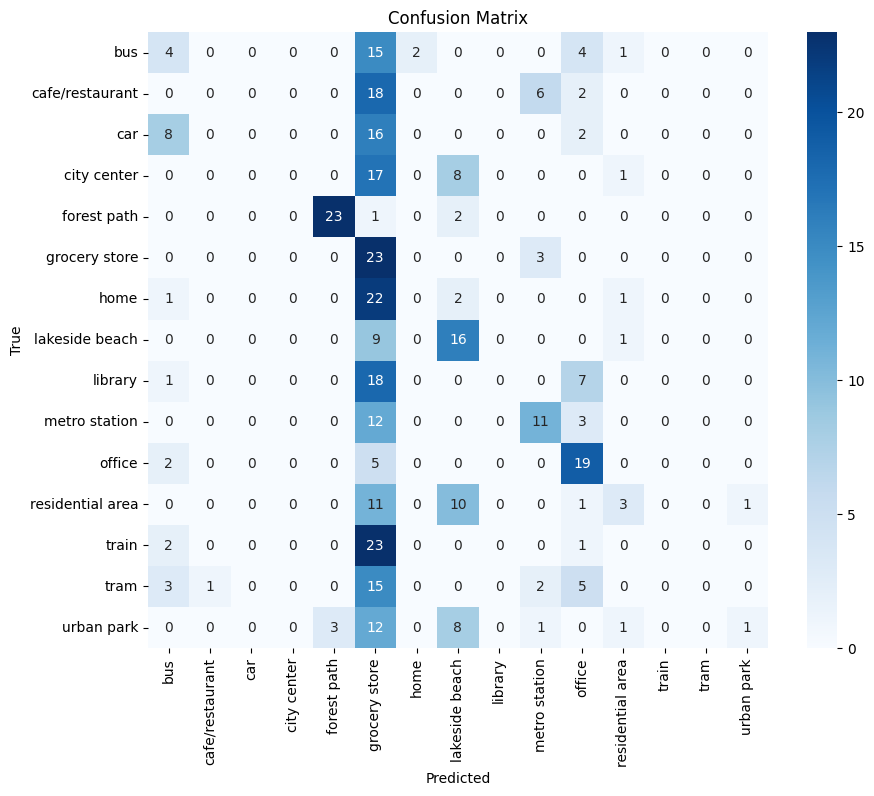


Number of mispredictions: 290
Index: 0, File Name: 212_class7.wav, True Label: lakeside beach, Predicted Label: residential area, Confidence Score: 0.0761
Confidence Scores for all classes:
  bus: 0.0693
  cafe/restaurant: 0.0663
  car: 0.0703
  city center: 0.0717
  forest path: 0.0589
  grocery store: 0.0674
  home: 0.0661
  lakeside beach: 0.0723
  library: 0.0713
  metro station: 0.0578
  office: 0.0522
  residential area: 0.0761
  train: 0.0663
  tram: 0.0615
  urban park: 0.0726
Index: 3, File Name: 198_class1.wav, True Label: cafe/restaurant, Predicted Label: metro station, Confidence Score: 0.5636
Confidence Scores for all classes:
  bus: 0.0174
  cafe/restaurant: 0.1424
  car: 0.0193
  city center: 0.0204
  forest path: 0.0133
  grocery store: 0.0102
  home: 0.0060
  lakeside beach: 0.0589
  library: 0.0248
  metro station: 0.5636
  office: 0.0127
  residential area: 0.0659
  train: 0.0188
  tram: 0.0128
  urban park: 0.0136
Index: 4, File Name: 17_class9.wav, True Label: met

In [69]:
def main(dev_audio_dir, eval_audio_dir, csv_path, eval_csv_path, output_dir):
    X_train_fused, X_val_fused, y_train, y_val, label_classes, file_names_train, file_names_val = prepare_data(dev_audio_dir, csv_path)

    y_train_cat = to_categorical(y_train, num_classes=len(label_classes))
    y_val_cat = to_categorical(y_val, num_classes=len(label_classes))

    input_shape = (X_train_fused.shape[1],)  # Define input shape for fused features
    print(f'Input shape for training data: {X_train_fused.shape}')
    print(f'Input shape for validation data: {X_val_fused.shape}')

    model = create_model(input_shape, len(label_classes))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)
    checkpoint = ModelCheckpoint(os.path.join(output_dir, 'best_model.keras'), save_best_only=True, monitor='val_accuracy')

    class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))

    history = model.fit(
        X_train_fused, y_train_cat, 
        validation_data=(X_val_fused, y_val_cat), 
        epochs=100, batch_size=32, 
        callbacks=[early_stopping, reduce_lr, checkpoint], 
        class_weight=class_weights_dict
    )

    X_eval_fused, y_eval, file_names_eval = prepare_eval_data(eval_audio_dir, eval_csv_path)
    evaluate_model(model, X_eval_fused, y_eval, file_names_eval, class_names)

if __name__ == '__main__':
    dev_audio_dir = '/kaggle/input/tut-2016/TUT_2016/TUT_Acoustic_scenes_development_all_in_one'
    eval_audio_dir = '/kaggle/input/tut-2016/TUT_2016/TUT_Acoustic_scenes_evaluation_all_in_one'
    csv_path = '/kaggle/input/i-vectors/i_vectors.csv'
    eval_csv_path = '/kaggle/input/i-vectors/i_vectors_eval.csv'
    output_dir = '/path/to/output'
    main(dev_audio_dir, eval_audio_dir, csv_path, eval_csv_path, output_dir)
